# Payment Date Prediction 


### Importing related Libraries 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from pandas.core.series import Series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

### Store the dataset into the Dataframe


In [2]:
#!gdown --id 1aYy_6BkRaSaUCsVuSm_BWMh8oWG0opsY ## downloading the dataset from the google drive link(works on colab only)
data=pd.read_csv("dataset.csv")

### Check the shape of the dataframe


In [3]:
data.shape

(50000, 19)

### Check the Detail information of the dataframe

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

### Display All the column names

In [5]:
data.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

### Describe the entire dataset

In [6]:
data.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999400e+04,50000.000000
mean,2019.305700,2.012238e+09,2.019351e+07,2.019354e+07,2.019368e+07,1.0,NaN,32337.021651,2.019354e+07,2.011340e+09,0.200000
std,0.460708,2.885235e+08,4.496041e+03,4.482134e+03,4.470614e+03,0.0,NaN,39205.975231,4.482701e+03,2.766335e+08,0.400004
min,2019.000000,1.928502e+09,2.018123e+07,2.018123e+07,2.018122e+07,1.0,NaN,0.720000,2.018121e+07,1.928502e+09,0.000000
25%,2019.000000,1.929342e+09,2.019050e+07,2.019051e+07,2.019052e+07,1.0,NaN,4928.312500,2.019050e+07,1.929342e+09,0.000000
50%,2019.000000,1.929964e+09,2.019091e+07,2.019091e+07,2.019093e+07,1.0,NaN,17609.010000,2.019091e+07,1.929964e+09,0.000000
75%,2020.000000,1.930619e+09,2.020013e+07,2.020013e+07,2.020022e+07,1.0,NaN,47133.635000,2.020013e+07,1.930619e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,668593.360000,2.020052e+07,2.960636e+09,1.000000


# Data Cleaning

- Show top 5 records from the dataset

In [7]:
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0


### Display the Null values percentage against every columns (compare to the total number of records)

- Output expected : area_business - 100% null, clear_data = 20% null, invoice_id = 0.12% null

In [8]:
null_count = data.isnull().sum()*100/50000
print("Column Name\tPercentage of Null Values\n")
for i,per in zip(data.columns,null_count):
    print(f"{i}\t {round(per, ndigits=4)}%")

Column Name	Percentage of Null Values

business_code	 0.0%
cust_number	 0.0%
name_customer	 0.0%
clear_date	 20.0%
buisness_year	 0.0%
doc_id	 0.0%
posting_date	 0.0%
document_create_date	 0.0%
document_create_date.1	 0.0%
due_in_date	 0.0%
invoice_currency	 0.0%
document type	 0.0%
posting_id	 0.0%
area_business	 100.0%
total_open_amount	 0.0%
baseline_create_date	 0.0%
cust_payment_terms	 0.0%
invoice_id	 0.012%
isOpen	 0.0%


### Display Invoice_id and Doc_Id

- Note - Many of the would have same invoice_id and doc_id


In [9]:
data[['invoice_id', 'doc_id']]

,invoice_id,doc_id
0,1.930438e+09,1.930438e+09
1,1.929646e+09,1.929646e+09
2,1.929874e+09,1.929874e+09
3,2.960623e+09,2.960623e+09
4,1.930148e+09,1.930148e+09
...,...,...
49995,1.930797e+09,1.930797e+09
49996,1.929744e+09,1.929744e+09
49997,1.930537e+09,1.930537e+09
49998,1.930199e+09,1.930199e+09


In [10]:
(data['doc_id'] == data['invoice_id']).sum()

49994

#### Write a code to check - 'baseline_create_date',"document_create_date",'document_create_date.1' - these columns are almost same.

- Please note, if they are same, we need to drop them later



In [11]:
data[['baseline_create_date','document_create_date','document_create_date.1']].corr().style.background_gradient(cmap='gist_ncar',vmin=0.999999)

,baseline_create_date,document_create_date,document_create_date.1
baseline_create_date,1.000000,0.994078,0.999527
document_create_date,0.994078,1.000000,0.994547
document_create_date.1,0.999527,0.994547,1.000000


#### Please check, Column 'posting_id' is constant columns or not


In [12]:
print("Number of unique values in posting_id column: ",data['posting_id'].nunique())
print("Hence Posting ID is a constant column")

Number of unique values in posting_id column:  1
Hence Posting ID is a constant column


#### Please check 'isOpen' is a constant column and relevant column for this project or not

In [13]:
print("Number of unique values in posting_id column: ",data['isOpen'].nunique())
print("\nNumber of value count of each unique value:\n",data['isOpen'].value_counts())
print("\nWe can see maximum rows are have same values and hence its a Quasi Constant column and needs to be dropped.")

Number of unique values in posting_id column:  2

Number of value count of each unique value:
 0    40000
1    10000
Name: isOpen, dtype: int64

We can see maximum rows are have same values and hence its a Quasi Constant column and needs to be dropped.


### Write the code to drop all the following columns from the dataframe

- 'area_business'
- "posting_id"
- "invoice_id"
- "document_create_date"
- "isOpen"
- 'document type' 
- 'document_create_date.1

In [14]:
drop_cols=['area_business',"posting_id","invoice_id","document_create_date","isOpen",'document type','document_create_date.1']
data=data.drop(columns=drop_cols)
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200210.0,USD,54273.28,20200126.0,NAH4
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190811.0,USD,79656.60,20190722.0,NAD1
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190929.0,USD,2253.86,20190914.0,NAA8
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200410.0,CAD,3299.70,20200331.0,CA10
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191128.0,USD,33133.29,20191113.0,NAH4


### Please check from the dataframe whether all the columns are removed or not 

In [15]:
print(data.columns)  
for i in drop_cols:
  if i not in data.columns:
    print("\nThe following column have been successfully dropped: ",i)

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'due_in_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms'],
      dtype='object')

The following column have been successfully dropped:  area_business

The following column have been successfully dropped:  posting_id

The following column have been successfully dropped:  invoice_id

The following column have been successfully dropped:  document_create_date

The following column have been successfully dropped:  isOpen

The following column have been successfully dropped:  document type

The following column have been successfully dropped:  document_create_date.1


### Show all the Dublicate rows from the dataframe

In [16]:
data[data.duplicated(keep = 'first')]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
1041,U001,0200769623,WAL-MAR in,2019-03-12 00:00:00,2019.0,1.928870e+09,2019-02-28,20190315.0,USD,19557.41,20190228.0,NAH4
2400,U001,0200769623,WAL-MAR trust,2019-08-28 00:00:00,2019.0,1.929758e+09,2019-08-18,20190902.0,USD,5600.41,20190818.0,NAH4
2584,U001,0200769623,WAL-MAR corporation,2019-12-16 00:00:00,2019.0,1.930217e+09,2019-12-04,20191219.0,USD,35352.17,20191204.0,NAH4
3755,U001,0200769623,WAL-MAR,2019-11-22 00:00:00,2019.0,1.930137e+09,2019-11-12,20191127.0,USD,2982.64,20191112.0,NAH4
3873,CA02,0140104409,LOB associates,NaN,2020.0,2.960629e+09,2020-04-14,20200425.0,CAD,82975.82,20200415.0,CA10
...,...,...,...,...,...,...,...,...,...,...,...,...
49928,U001,0200915438,GROC trust,2019-08-15 00:00:00,2019.0,1.929646e+09,2019-07-25,20190809.0,USD,6969.00,20190725.0,NAA8
49963,U001,0200759878,SA us,2019-01-29 00:00:00,2019.0,1.928614e+09,2019-01-13,20190128.0,USD,10968.24,20190113.0,NAH4
49986,U001,0200772670,ASSOCIAT foundation,2019-06-12 00:00:00,2019.0,1.929403e+09,2019-05-29,20190613.0,USD,155837.53,20190529.0,NAU5
49990,U001,0200765011,MAINES llc,2019-06-06 00:00:00,2019.0,1.929365e+09,2019-05-22,20190606.0,USD,4008.05,20190522.0,NAA8


### Display the Number of Dublicate Rows

In [17]:
(data.duplicated()==True).sum()

1161

### Drop all the Dublicate Rows

In [18]:
data=data.drop_duplicates(keep = 'first')

#### Now check for all dublicate rows now

- Note - It must be 0 by now

In [19]:
(data.duplicated()==True).sum()

0

### Check for the number of Rows and Columns in your dataset

In [20]:
data.shape

(48839, 12)

### Find out the total count of null values in each columns

In [21]:
data.isnull().sum()

business_code              0
cust_number                0
name_customer              0
clear_date              9681
buisness_year              0
doc_id                     0
posting_date               0
due_in_date                0
invoice_currency           0
total_open_amount          0
baseline_create_date       0
cust_payment_terms         0
dtype: int64

#Data type Conversion 

### Please check the data type of each column of the dataframe

In [22]:
data.dtypes

business_code            object
cust_number              object
name_customer            object
clear_date               object
buisness_year           float64
doc_id                  float64
posting_date             object
due_in_date             float64
invoice_currency         object
total_open_amount       float64
baseline_create_date    float64
cust_payment_terms       object
dtype: object

### Check the datatype format of below columns

- clear_date  
- posting_date
- due_in_date 
- baseline_create_date

In [23]:
check_dtype =['clear_date','posting_date','due_in_date','baseline_create_date']
pd.DataFrame({'COLUMNS':list(check_dtype) ,'Data Type':data.dtypes[check_dtype]})

,COLUMNS,Data Type
clear_date,clear_date,object
posting_date,posting_date,object
due_in_date,due_in_date,float64
baseline_create_date,baseline_create_date,float64


### converting date columns into date time formats

- clear_date  
- posting_date
- due_in_date 
- baseline_create_date


- **Note - You have to convert all these above columns into "%Y%m%d" format**

In [24]:
# Function to convert float columns to int and then to string for passing in datetime method
def convert_to_string(data,cols):
    for i in cols:
        data[i] = data[i].astype(np.int64)
        data[i] = data[i].astype(str)
    return data

#Calling the function on our dataframe
data = convert_to_string(data,['baseline_create_date','due_in_date'])

# Converting all the mentioned columns to datetime format
date_cols = ['baseline_create_date','due_in_date','clear_date','posting_date']
for x in date_cols:
    data[x] = pd.to_datetime(data[x],format='%Y-%m-%d')

### Please check the datatype of all the columns after conversion of the above 4 columns

In [25]:
pd.DataFrame({'COLUMNS':list(date_cols) ,'Data Type':data.dtypes[date_cols]})

,COLUMNS,Data Type
baseline_create_date,baseline_create_date,datetime64[ns]
due_in_date,due_in_date,datetime64[ns]
clear_date,clear_date,datetime64[ns]
posting_date,posting_date,datetime64[ns]


#### the invoice_currency column contains two different categories, USD and CAD

- Please do a count of each currency 

In [26]:
data['invoice_currency'].value_counts()

USD    45011
CAD     3828
Name: invoice_currency, dtype: int64

#### display the "total_open_amount" column value

In [27]:
pd.DataFrame(data['total_open_amount'])

,total_open_amount
0,54273.28
1,79656.60
2,2253.86
3,3299.70
4,33133.29
...,...
49995,3187.86
49996,6766.54
49997,6120.86
49998,63.48


### Convert all CAD into USD currency of "total_open_amount" column

- 1 CAD = 0.7 USD
- Create a new column i.e "converted_usd" and store USD and convered CAD to USD

In [28]:
data['converted_usd'] = np.where((data['invoice_currency']=='CAD'),data['total_open_amount']*0.7,data['total_open_amount'])

In [29]:
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,USD,54273.28,2020-01-26,NAH4,54273.28
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,USD,79656.60,2019-07-22,NAD1,79656.60
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,USD,2253.86,2019-09-14,NAA8,2253.86
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,CAD,3299.70,2020-03-31,CA10,2309.79
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,USD,33133.29,2019-11-13,NAH4,33133.29


### Display the new "converted_usd" column values

In [30]:
pd.DataFrame(data['converted_usd'])

,converted_usd
0,54273.28
1,79656.60
2,2253.86
3,2309.79
4,33133.29
...,...
49995,3187.86
49996,6766.54
49997,6120.86
49998,63.48


### Display year wise total number of record 

- Note -  use "buisness_year" column for this 

In [31]:
data['buisness_year'].value_counts()

2019.0    33975
2020.0    14864
Name: buisness_year, dtype: int64

### Write the code to delete the following columns 

- 'invoice_currency'
- 'total_open_amount', 

In [32]:
del_cols = ['invoice_currency','total_open_amount']
data=data.drop(columns=del_cols)
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.28
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.60
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.86
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.29


### Write a code to check the number of columns in dataframe

In [33]:
print("Number of remaining columns in the data: ",data.shape[1],"\n")
print(data.columns)

Number of remaining columns in the data:  11 

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'due_in_date',
       'baseline_create_date', 'cust_payment_terms', 'converted_usd'],
      dtype='object')


# Splitting the Dataset 

### Look for all columns containing null value

- Note - Output expected is only one column 

In [34]:
data.columns[data.isna().any()].to_list()

['clear_date']

#### Find out the number of null values from the column that you got from the above code

In [35]:
data['clear_date'].isna().sum()

9681

### On basis of the above column we are spliting data into dataset

- First dataframe (refer that as maindata) only containing the rows, that have NULL data in that column ( This is going to be our train dataset ) 
- Second dataframe (refer that as nulldata) that contains the columns, that have Not Null data in that column ( This is going to be our test dataset ) 

In [36]:
maindata = data.loc[~data['clear_date'].isnull()]
maindata = maindata.reset_index(drop=True)
nulldata = data.loc[data['clear_date'].isnull()]

### Check the number of Rows and Columns for both the dataframes 

In [37]:
maindata.shape

(39158, 11)

In [38]:
nulldata.shape

(9681, 11)

### Display the 5 records from maindata and nulldata dataframes

In [39]:
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088


In [40]:
nulldata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06


## Considering the **maindata**

#### Generate a new column "Delay" from the existing columns

- Note - You are expected to create a new column 'Delay' from two existing columns, "clear_date" and "due_in_date" 
- Formula - Delay = clear_date - due_in_date

In [41]:
maindata['Delay'] = (maindata['clear_date'] - maindata['due_in_date'])
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,1 days
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,-3 days
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,92 days
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-3 days
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,61 days


### Generate a new column "avgdelay" from the existing columns

- Note - You are expected to make a new column "avgdelay" by grouping "name_customer" column with reapect to mean of the "Delay" column.
- This new column "avg_delay" is meant to store "customer_name" wise delay
- groupby('name_customer')['Delay'].mean(numeric_only=False)
- Display the new "avg_delay" column

In [42]:
avg_del = maindata.groupby('name_customer')['Delay'].mean(numeric_only=False).to_frame()
avg_del.rename(columns = {'Delay':'avg_del'},inplace=True)
avg_del.head()

,avg_del
name_customer,
11078 us,17 days
17135 associates,-10 days
17135 llc,-3 days
236008 associates,-3 days
99 CE,2 days


You need to add the "avg_delay" column with the maindata, mapped with "name_customer" column

 - Note - You need to use map function to map the avgdelay with respect to "name_customer" column

In [43]:
maindata['avg_delay'] = maindata['name_customer'].map(avg_del['avg_del'])
maindata

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay,avg_delay
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,1 days,-3 days +07:08:49.779837776
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,-3 days,19 days 00:00:00
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,92 days,8 days 02:10:54.545454545
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-3 days,-3 days +19:33:27.692307693
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,61 days,71 days 10:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39153,U001,0200762301,C&S WH trust,2019-07-25,2019.0,1.929601e+09,2019-07-10,2019-07-25,2019-07-10,NAC6,84780.400,0 days,-1 days +14:45:00
39154,U001,0200769623,WAL-MAR co,2019-09-03,2019.0,1.929744e+09,2019-08-15,2019-08-30,2019-08-15,NAH4,6766.540,4 days,-3 days +12:40:08.540925267
39155,U001,0200772595,SAFEW associates,2020-03-05,2020.0,1.930537e+09,2020-02-19,2020-03-05,2020-02-19,NAA8,6120.860,0 days,1 days 01:08:34.285714285
39156,U001,0200726979,BJ'S llc,2019-12-12,2019.0,1.930199e+09,2019-11-27,2019-12-12,2019-11-27,NAA8,63.480,0 days,1 days 13:36:42.985074626


### Observe that the "avg_delay" column is in days format. You need to change the format into seconds

- Days_format :  17 days 00:00:00
- Format in seconds : 1641600.0

In [44]:
maindata['avg_delay'] = maindata['avg_delay'].dt.total_seconds()

### Display the maindata dataframe 

In [45]:
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay,avg_delay
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,1 days,-2.334702e+05
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,-3 days,1.641600e+06
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,92 days,6.990545e+05
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-3 days,-1.887923e+05
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,61 days,6.172800e+06


### Since you have created the "avg_delay" column from "Delay" and "clear_date" column, there is no need of these two columns anymore 

- You are expected to drop "Delay" and "clear_date" columns from maindata dataframe 

In [46]:
drop = ['Delay','clear_date']
maindata = maindata.drop(columns=drop)
maindata.head()

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,U001,0200769623,WAL-MAR corp,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,-2.334702e+05
1,U001,0200980828,BEN E,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,1.641600e+06
2,U001,0200792734,MDV/ trust,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,6.990545e+05
3,U001,0200769623,WAL-MAR foundation,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-1.887923e+05
4,CA02,0140106181,THE corporation,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,6.172800e+06


# Splitting of Train and the Test Data

### You need to split the "maindata" columns into X and y dataframe

- Note - y should have the target column i.e. "avg_delay" and the other column should be in X

- X is going to hold the source fields and y will be going to hold the target fields

In [47]:
X = maindata.iloc[:, 0:10]
X.head()

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280
1,U001,0200980828,BEN E,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600
2,U001,0200792734,MDV/ trust,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860
3,U001,0200769623,WAL-MAR foundation,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290
4,CA02,0140106181,THE corporation,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088


In [48]:
Y = maindata.iloc[:,-1:]
Y.head()

,avg_delay
0,-2.334702e+05
1,1.641600e+06
2,6.990545e+05
3,-1.887923e+05
4,6.172800e+06


#### You are expected to split both the dataframes into train and test format in 60:40 ratio 

- Note - The expected output should be in "X_train", "X_loc_test", "y_train", "y_loc_test" format 

In [49]:
X_train, X_loc_test, y_train, y_loc_test = train_test_split(X, Y, test_size=0.4)

### Please check for the number of rows and columns of all the new dataframes (all 4)

In [50]:
print(X_train.shape)
print(X_loc_test.shape)
print(y_train.shape)
print(y_loc_test.shape)

(23494, 10)
(15664, 10)
(23494, 1)
(15664, 1)


### Now you are expected to split the "X_loc_test" and "y_loc_test" dataset into "Test" and "Validation" (as the names given below) dataframe with 50:50 format 

- Note - The expected output should be in "X_val", "X_test", "y_val", "y_test" format

In [51]:
X_val,X_test,y_val,y_test = train_test_split(X_loc_test, y_loc_test, test_size=0.5)

### Please check for the number of rows and columns of all the 4 dataframes 

In [52]:
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_test.shape)

(7832, 10)
(7832, 10)
(7832, 1)
(7832, 1)


# Exploratory Data Analysis (EDA) 

### Distribution Plot of the target variable (use the dataframe which contains the target field)

- Note - You are expected to make a distribution plot for the target variable 

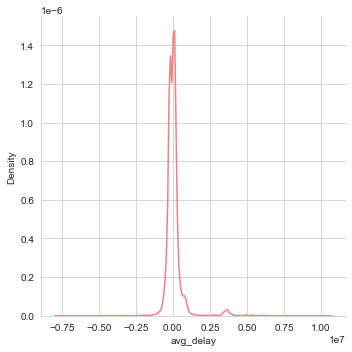

In [53]:
sns.set_style("whitegrid")
sns.displot(data=y_train,kind="kde",color ='#F08080',x='avg_delay')

### You are expected to group the X_train dataset on 'name_customer' column with 'doc_id' in the x_train set

### Need to store the outcome into a new dataframe 

- Note code given for groupby statement- X_train.groupby(by=['name_customer'], as_index=False)['doc_id'].count()

In [54]:
x_train = pd.DataFrame((X_train.groupby(by=['name_customer'], as_index=False)['doc_id'].count()))
x_train

,name_customer,doc_id
0,17135 associates,1
1,17135 llc,1
2,236008 associates,1
3,99 CE,1
4,99 CE associates,2
...,...,...
3053,Y H trust,2
3054,YAEGER corp,1
3055,YEN BROS corporation,1
3056,YEN BROS llc,1


### You can make another distribution plot of the "doc_id" column from x_train

C:\Users\Professor\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


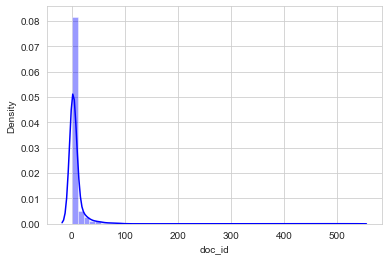

In [55]:
sns.distplot(x_train['doc_id'],color='blue')
plt.show()

#### Create a Distribution plot only for business_year and a seperate distribution plot of "business_year" column along with the doc_id" column


C:\Users\Professor\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='buisness_year', ylabel='Density'>

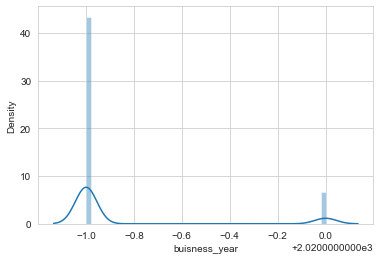

In [56]:
sns.distplot(X_train['buisness_year'])

C:\Users\Professor\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

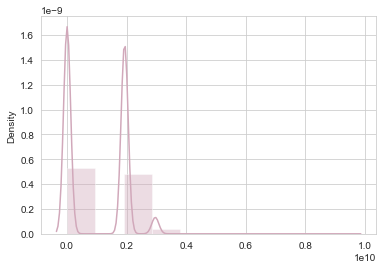

In [57]:
sns.distplot(X_train[['buisness_year','doc_id']],color='#D1A8BA', bins =10)

# Feature Engineering 

### Display and describe the X_train dataframe 

In [58]:
X_train

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
29540,U001,0200769623,WAL-MAR corp,2020.0,1.930341e+09,2020-01-01,2020-01-16,2020-01-01,NAH4,829.50
4848,U001,0200759878,SA trust,2020.0,1.930474e+09,2020-02-04,2020-02-19,2020-02-04,NAH4,14791.46
20980,U001,0200769623,WAL-MAR trust,2020.0,1.930426e+09,2020-01-23,2020-02-07,2020-01-23,NAH4,276.52
1958,U001,0200759878,SA llc,2019.0,1.929050e+09,2019-03-29,2019-04-14,2019-03-30,NAH4,61098.03
21122,U001,0200744019,TARG llc,2019.0,1.929908e+09,2019-09-21,2019-10-06,2019-09-21,NAA8,5807.96
...,...,...,...,...,...,...,...,...,...,...
23791,U001,0200002965,DECA corp,2019.0,1.930029e+09,2019-10-18,2019-10-26,2019-10-16,NAM2,525663.66
13024,U001,0200742521,GLA co,2019.0,1.930044e+09,2019-10-22,2019-11-06,2019-10-22,NAA8,29069.80
34103,U001,0200253680,SCHWANS corp,2019.0,1.929278e+09,2019-05-07,2019-05-22,2019-05-07,NAA8,45400.00
20850,U001,0200761497,NEX llc,2019.0,1.929195e+09,2019-04-23,2019-05-08,2019-04-23,NAA8,154.44


In [59]:
X_train.describe()

,buisness_year,doc_id,converted_usd
count,23494.000000,2.349400e+04,23494.000000
mean,2019.131608,2.013881e+09,30933.149558
std,0.338071,2.954219e+08,36947.112813
min,2019.000000,1.928502e+09,0.790000
25%,2019.000000,1.929175e+09,4452.187500
50%,2019.000000,1.929726e+09,16921.628500
75%,2019.000000,1.930207e+09,45950.420000
max,2020.000000,9.500000e+09,632134.240000


#### The "business_code" column inside X_train, is a categorical column, so you need to perform Labelencoder on that particular column

- Note - call the Label Encoder from sklearn library and use the fit() function on "business_code" column
- Note - Please fill in the blanks (two) to complete this code

In [60]:
from sklearn.preprocessing import LabelEncoder
business_coder = LabelEncoder()
business_coder.fit(X_train['business_code'])

LabelEncoder()

#### You are expected to store the value into a new column i.e. "business_code_enc"

- Note - For Training set you are expected to use fit_trainsform()
- Note - For Test set you are expected to use the trainsform()
- Note - For Validation set you are expected to use the trainsform()


- Partial code is provided, please fill in the blanks 

In [61]:
X_train['business_code_enc'] = business_coder.fit_transform(X_train['business_code'])

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/2646772204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['business_code_enc'] = business_coder.fit_transform(X_train['business_code'])


In [62]:
X_val['business_code_enc'] = business_coder.transform(X_val['business_code'])
X_test['business_code_enc'] = business_coder.transform(X_test['business_code'])

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/4097299337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['business_code_enc'] = business_coder.transform(X_val['business_code'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/4097299337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['business_code_enc'] = business_coder.transform(X_test['business_code'])


### Display "business_code" and "business_code_enc" together from X_train dataframe 

In [63]:
pd.DataFrame(X_train[['business_code','business_code_enc']])

,business_code,business_code_enc
29540,U001,1
4848,U001,1
20980,U001,1
1958,U001,1
21122,U001,1
...,...,...
23791,U001,1
13024,U001,1
34103,U001,1
20850,U001,1


#### Create a function called "custom" for dropping the columns 'business_code' from train, test and validation dataframe

- Note - Fill in the blank to complete the code

In [64]:
def custom(col ,traindf = X_train,valdf = X_val,testdf = X_test):
    traindf.drop(col, axis =1,inplace=True)
    valdf.drop(col,axis=1 , inplace=True)
    testdf.drop(col,axis=1 , inplace=True)

    return traindf,valdf ,testdf

### Call the function by passing the column name which needed to be dropped from train, test and validation dataframes. Return updated dataframes to be stored in X_train ,X_val, X_test  

- Note = Fill in the blank to complete the code 

In [65]:
X_train , X_val , X_test = custom(['business_code'])

C:\Users\Professor\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Manually replacing str values with numbers, Here we are trying manually replace the customer numbers with some specific values like, 'CCCA' as 1, 'CCU' as 2 and so on. Also we are converting the datatype "cust_number" field to int type.

- We are doing it for all the three dataframes as shown below. This is fully completed code. No need to modify anything here 



In [66]:
X_train['cust_number'] = X_train['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)
X_test['cust_number'] = X_test['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)
X_val['cust_number'] = X_val['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)


C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1250852798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cust_number'] = X_train['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1250852798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cust_number'] = X_test['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)
C:\Users\PROFES~

#### It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]. Unknown will be added in fit and transform will take care of new item. It gives unknown class id.

#### This will fit the encoder for all the unique values and introduce unknown value

- Note - Keep this code as it is, we will be using this later on.  

In [67]:
#For encoding unseen labels
class EncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()
    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self
    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)

### Use the user define Label Encoder function called "EncoderExt" for the "name_customer" column

- Note - Keep the code as it is, no need to change

In [68]:
label_encoder = EncoderExt()
label_encoder.fit(X_train['name_customer'])
X_train['name_customer_enc']=label_encoder.transform(X_train['name_customer'])
X_val['name_customer_enc']=label_encoder.transform(X_val['name_customer'])
X_test['name_customer_enc']=label_encoder.transform(X_test['name_customer'])

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1721247874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['name_customer_enc']=label_encoder.transform(X_train['name_customer'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1721247874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['name_customer_enc']=label_encoder.transform(X_val['name_customer'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1721247874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

### As we have created the a new column "name_customer_enc", so now drop "name_customer" column from all three dataframes

- Note - Keep the code as it is, no need to change

In [69]:
X_train ,X_val, X_test = custom(['name_customer'])

### Using Label Encoder for the "cust_payment_terms" column

- Note - Keep the code as it is, no need to change

In [70]:
label_encoder1 = EncoderExt()
label_encoder1.fit(X_train['cust_payment_terms'])
X_train['cust_payment_terms_enc']=label_encoder1.transform(X_train['cust_payment_terms'])
X_val['cust_payment_terms_enc']=label_encoder1.transform(X_val['cust_payment_terms'])
X_test['cust_payment_terms_enc']=label_encoder1.transform(X_test['cust_payment_terms'])

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1215482524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cust_payment_terms_enc']=label_encoder1.transform(X_train['cust_payment_terms'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1215482524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['cust_payment_terms_enc']=label_encoder1.transform(X_val['cust_payment_terms'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1215482524.py:5: SettingWithCopyWarning: 
A value is t

In [71]:
X_train ,X_val, X_test = custom(['cust_payment_terms'])

## Check the datatype of all the columns of Train, Test and Validation dataframes realted to X

- Note - You are expected yo use dtype

In [72]:
X_train.dtypes

cust_number                        int64
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
converted_usd                    float64
business_code_enc                  int32
name_customer_enc                  int32
cust_payment_terms_enc             int32
dtype: object

In [73]:
X_val.dtypes

cust_number                        int64
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
converted_usd                    float64
business_code_enc                  int32
name_customer_enc                  int32
cust_payment_terms_enc             int32
dtype: object

In [74]:
X_test.dtypes

cust_number                        int64
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
converted_usd                    float64
business_code_enc                  int32
name_customer_enc                  int32
cust_payment_terms_enc             int32
dtype: object

### From the above output you can notice their are multiple date columns with datetime format

### In order to pass it into our model, we need to convert it into float format

### You need to extract day, month and year from the "posting_date" column 

1.   Extract days from "posting_date" column and store it into a new column "day_of_postingdate" for train, test and validation dataset 
2.   Extract months from "posting_date" column and store it into a new column "month_of_postingdate" for train, test and validation dataset
3.   Extract year from "posting_date" column and store it into a new column "year_of_postingdate" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year






In [75]:
X_train['day_of_postingdate'] = X_train['posting_date'].dt.day
X_train['month_of_postingdate'] = X_train['posting_date'].dt.month
X_train['year_of_postingdate'] = X_train['posting_date'].dt.year

X_val['day_of_postingdate'] = X_val['posting_date'].dt.day
X_val['month_of_postingdate'] = X_val['posting_date'].dt.month
X_val['year_of_postingdate'] = X_val['posting_date'].dt.year


X_test['day_of_postingdate'] = X_test['posting_date'].dt.day
X_test['month_of_postingdate'] = X_test['posting_date'].dt.month
X_test['year_of_postingdate'] = X_test['posting_date'].dt.year



C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/344803791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day_of_postingdate'] = X_train['posting_date'].dt.day
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/344803791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['month_of_postingdate'] = X_train['posting_date'].dt.month
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/344803791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

### pass the "posting_date" column into the Custom function for train, test and validation dataset

In [76]:
X_train ,X_val, X_test = custom(['posting_date'])

### You need to extract day, month and year from the "baseline_create_date" column 

1.   Extract days from "baseline_create_date" column and store it into a new column "day_of_createdate" for train, test and validation dataset 
2.   Extract months from "baseline_create_date" column and store it into a new column "month_of_createdate" for train, test and validation dataset
3.   Extract year from "baseline_create_date" column and store it into a new column "year_of_createdate" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year


- Note - Do as it is been shown in the previous two code boxes

### Extracting Day, Month, Year for 'baseline_create_date' column

In [77]:
X_train['day_of_createdate'] = X_train['baseline_create_date'].dt.day
X_train['month_of_createdate'] = X_train['baseline_create_date'].dt.month
X_train['year_of_createdate'] = X_train['baseline_create_date'].dt.year

X_val['day_of_createdate'] = X_val['baseline_create_date'].dt.day
X_val['month_of_createdate'] = X_val['baseline_create_date'].dt.month
X_val['year_of_createdate'] = X_val['baseline_create_date'].dt.year


X_test['day_of_createdate'] = X_test['baseline_create_date'].dt.day
X_test['month_of_createdate'] = X_test['baseline_create_date'].dt.month
X_test['year_of_createdate'] = X_test['baseline_create_date'].dt.year

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/308766609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day_of_createdate'] = X_train['baseline_create_date'].dt.day
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/308766609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['month_of_createdate'] = X_train['baseline_create_date'].dt.month
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/308766609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

### pass the "baseline_create_date" column into the Custom function for train, test and validation dataset

In [78]:
X_train ,X_val, X_test = custom(['baseline_create_date'])

### You need to extract day, month and year from the "due_in_date" column 

1.   Extract days from "due_in_date" column and store it into a new column "day_of_due" for train, test and validation dataset 
2.   Extract months from "due_in_date" column and store it into a new column "month_of_due" for train, test and validation dataset
3.   Extract year from "due_in_date" column and store it into a new column "year_of_due" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year

- Note - Do as it is been shown in the previous code

In [79]:
X_train['day_of_due'] = X_train['due_in_date'].dt.day
X_train['month_of_due'] = X_train['due_in_date'].dt.month
X_train['year_of_due'] = X_train['due_in_date'].dt.year

X_val['day_of_due'] = X_val['due_in_date'].dt.day
X_val['month_of_due'] = X_val['due_in_date'].dt.month
X_val['year_of_due'] = X_val['due_in_date'].dt.year


X_test['day_of_due'] = X_test['due_in_date'].dt.day
X_test['month_of_due'] = X_test['due_in_date'].dt.month
X_test['year_of_due'] = X_test['due_in_date'].dt.year

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/3335151538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['day_of_due'] = X_train['due_in_date'].dt.day
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/3335151538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['month_of_due'] = X_train['due_in_date'].dt.month
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/3335151538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

pass the "due_in_date" column into the Custom function for train, test and validation dataset

In [80]:
X_train ,X_val, X_test = custom(['due_in_date'])

### Check for the datatypes for train, test and validation set again

- Note - all the data type should be in either int64 or float64 format 


In [81]:
X_train.dtypes

cust_number                 int64
buisness_year             float64
doc_id                    float64
converted_usd             float64
business_code_enc           int32
name_customer_enc           int32
cust_payment_terms_enc      int32
day_of_postingdate          int64
month_of_postingdate        int64
year_of_postingdate         int64
day_of_createdate           int64
month_of_createdate         int64
year_of_createdate          int64
day_of_due                  int64
month_of_due                int64
year_of_due                 int64
dtype: object

In [82]:
X_val.dtypes

cust_number                 int64
buisness_year             float64
doc_id                    float64
converted_usd             float64
business_code_enc           int32
name_customer_enc           int32
cust_payment_terms_enc      int32
day_of_postingdate          int64
month_of_postingdate        int64
year_of_postingdate         int64
day_of_createdate           int64
month_of_createdate         int64
year_of_createdate          int64
day_of_due                  int64
month_of_due                int64
year_of_due                 int64
dtype: object

In [83]:
X_test.dtypes

cust_number                 int64
buisness_year             float64
doc_id                    float64
converted_usd             float64
business_code_enc           int32
name_customer_enc           int32
cust_payment_terms_enc      int32
day_of_postingdate          int64
month_of_postingdate        int64
year_of_postingdate         int64
day_of_createdate           int64
month_of_createdate         int64
year_of_createdate          int64
day_of_due                  int64
month_of_due                int64
year_of_due                 int64
dtype: object

# Feature Selection

### Filter Method

- Calling the VarianceThreshold Function 
- Note - Keep the code as it is, no need to change 

In [84]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
len(X_train.columns[constant_filter.get_support()])

16

- Note - Keep the code as it is, no need to change 


In [85]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]
print(len(constant_columns))

0


- transpose the feature matrice
- print the number of duplicated features
- select the duplicated features columns names

- Note - Keep the code as it is, no need to change 


In [86]:
x_train_T = X_train.T
print(x_train_T.duplicated().sum())
duplicated_columns = x_train_T[x_train_T.duplicated()].index.values

0


### Filtering depending upon correlation matrix value
- We have created a function called handling correlation which is going to return fields based on the correlation matrix value with a threshold of 0.8

- Note - Keep the code as it is, no need to change 

In [87]:
def handling_correlation(X_train,threshold=0.8):
    corr_features = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

- Note : Here we are trying to find out the relevant fields, from X_train
- Please fill in the blanks to call handling_correlation() function with a threshold value of 0.85

In [88]:
train=X_train.copy()
handling_correlation(train,threshold=0.85)

['year_of_postingdate',
 'year_of_due',
 'month_of_createdate',
 'day_of_createdate',
 'month_of_due',
 'year_of_createdate']

### Heatmap for X_train

- Note - Keep the code as it is, no need to change

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

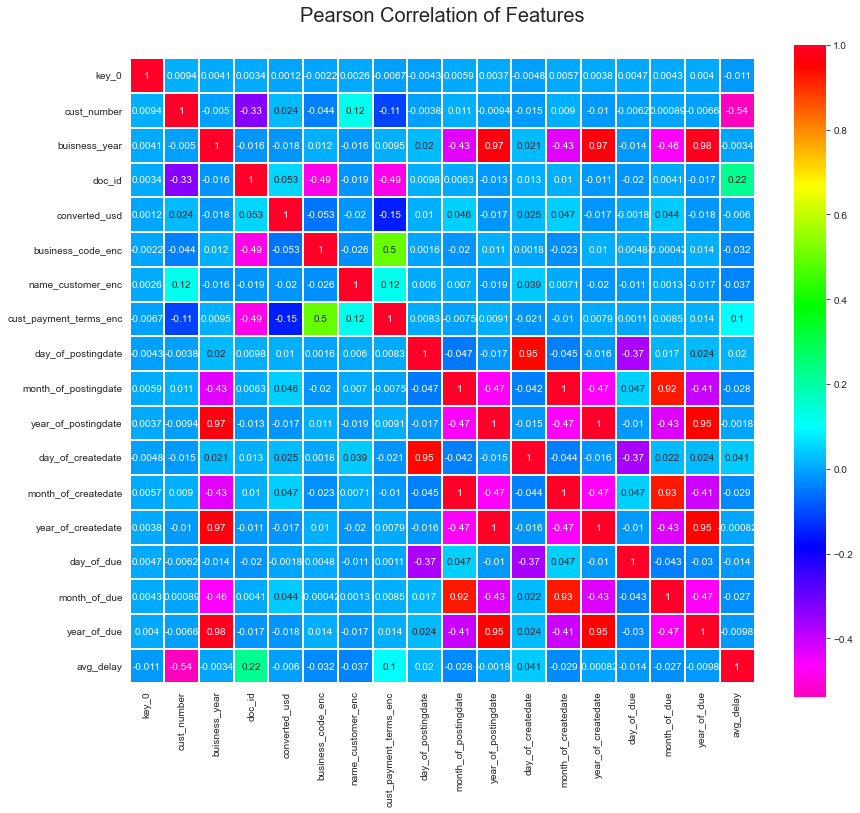

In [89]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='gist_rainbow_r', linecolor='white', annot=True)

#### Calling variance threshold for threshold value = 0.8

- Note -  Fill in the blanks to call the appropriate method

In [90]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.8)
sel.fit(X_train)

VarianceThreshold(threshold=0.8)

In [91]:
sel.variances_

array([1.79893223e+15, 1.14287386e-01, 8.72703573e+16, 1.36503104e+09,
       2.89117772e-01, 1.04343634e+06, 1.22388295e+02, 7.60321784e+01,
       1.22786347e+01, 1.14915287e-01, 7.75252243e+01, 1.22875284e+01,
       1.15075287e-01, 7.58867423e+01, 1.20981769e+01, 1.17389522e-01])

### Important features columns are 
- 'year_of_createdate' 
- 'year_of_due'
- 'day_of_createdate'
- 'year_of_postingdate'
- 'month_of_due'
- 'month_of_createdate'

# Modelling 

#### Now you need to compare with different machine learning models, and needs to find out the best predicted model

- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Support Vector Regression
- Extreme Gradient Boost Regression 

### You need to make different blank list for different evaluation matrix 

- MSE
- R2
- Algorithm

In [92]:
MSE_Score = []
R2_Score = []
Algorithm = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### You need to start with the baseline model Linear Regression

- Step 1 : Call the Linear Regression from sklearn library
- Step 2 : make an object of Linear Regression 
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [93]:
from sklearn.linear_model import LinearRegression
Algorithm.append('LinearRegression')
regressor = LinearRegression()
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [94]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

In [95]:
print("MSE Score on Train Data: ",mean_squared_error(y_test, predicted))
print("R2 Score on Train Data: ",r2_score(y_test, predicted))

MSE Score on Train Data:  312310032266.507
R2 Score on Train Data:  0.31584960427842135


### Check the same for the Validation set also 

In [96]:
predict_test= regressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, predict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, predict_test))

MSE Score on Validation Data:  517823.53545000334
R2 Score on Validation:  0.351163578580007


### Display The Comparison Lists

In [97]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression'],[312310032266.507],[0.31584960427842135],

### You need to start with the baseline model Support Vector Regression

- Step 1 : Call the Support Vector Regressor from sklearn library
- Step 2 : make an object of SVR
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [98]:
from sklearn.svm import SVR
Algorithm.append('Support Vector Regression')
svmregressor = SVR()
svmregressor.fit(X_train, y_train.values.ravel())
svmpredicted= svmregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for "y_test" and "predicted" dataset and store those data inside respective list for comparison 

In [99]:
MSE_Score.append(mean_squared_error(y_test, svmpredicted))
R2_Score.append(r2_score(y_test, svmpredicted))

In [100]:
print("MSE Score on Train Data: ",mean_squared_error(y_test, svmpredicted))
print("R2 Score on Train Data: ",r2_score(y_test, svmpredicted))

MSE Score on Train Data:  459878684811.3005
R2 Score on Train Data:  -0.00741619445989139


### Check the same for the Validation set also 

In [101]:
svmpredict_test= svmregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, svmpredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, svmpredict_test))

MSE Score on Validation Data:  645147.6577201483
R2 Score on Validation:  -0.007140125293871202


### Display The Comparison Lists

In [102]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression'],[312310032266.507, 459878684811.3005],[0.31584960427842135, -0.00741619445989139],

### Your next model would be Decision Tree Regression

- Step 1 : Call the Decision Tree Regressor from sklearn library
- Step 2 : make an object of Decision Tree
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [103]:
from sklearn.tree import DecisionTreeRegressor
Algorithm.append('Decision Tree Regression')
dsregressor = DecisionTreeRegressor()
dsregressor.fit(X_train, y_train.values.ravel())
dspredicted= dsregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [104]:
MSE_Score.append(mean_squared_error(y_test, dspredicted))
R2_Score.append(r2_score(y_test, dspredicted))

In [105]:
print("MSE Score on Train Data: ",mean_squared_error(y_test, dspredicted))
print("R2 Score on Train Data: ",r2_score(y_test, dspredicted))

MSE Score on Train Data:  173302071960.15677
R2 Score on Train Data:  0.6203622398856063


### Check the same for the Validation set also 

In [106]:
dspredict_test= dsregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, dspredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, dspredict_test))

MSE Score on Validation Data:  480782.9558134611
R2 Score on Validation:  0.4406678595930513


### Display The Comparison Lists

In [107]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression'],[312310032266.507, 459878684811.3005, 173302071960.15677],[0.31584960427842135, -0.00741619445989139, 0.6203622398856063],

### Your next model would be Random Forest Regression

- Step 1 : Call the Random Forest Regressor from sklearn library
- Step 2 : make an object of Random Forest
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [108]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('Random Forest Regression')
rfregressor = RandomForestRegressor()
rfregressor.fit(X_train, y_train.values.ravel())
rfpredicted= rfregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [109]:
MSE_Score.append(mean_squared_error(y_test, rfpredicted))
R2_Score.append(r2_score(y_test, rfpredicted))

In [110]:
print("MSE Score on Train Data: ",mean_squared_error(y_test, rfpredicted))
print("R2 Score on Train Data: ",r2_score(y_test, rfpredicted))

MSE Score on Train Data:  125008838791.5414
R2 Score on Train Data:  0.7261540210307871


### Check the same for the Validation set also 

In [111]:
rfpredict_test= rfregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, rfpredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, rfpredict_test))

MSE Score on Validation Data:  346498.6467192542
R2 Score on Validation:  0.7094808700922529


### Display The Comparison Lists


In [112]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression', 'Random Forest Regression'],[312310032266.507, 459878684811.3005, 173302071960.15677, 125008838791.5414],[0.31584960427842135, -0.00741619445989139, 0.6203622398856063, 0.7261540210307871],

### The last but not the least model would be XGBoost or Extreme Gradient Boost Regression

- Step 1 : Call the XGBoost Regressor from xgb library
- Step 2 : make an object of Xgboost
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose### Extreme Gradient Boost Regression
- Note -  No need to change the code 

In [113]:
import xgboost as xgb
Algorithm.append('XGB Regressor')
xgbregressor = xgb.XGBRegressor()
xgbregressor.fit(X_train, y_train)
xgbpredicted = xgbregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [114]:
MSE_Score.append(mean_squared_error(y_test, xgbpredicted))
R2_Score.append(r2_score(y_test, xgbpredicted))

In [115]:
print("MSE Score on Train Data: ",mean_squared_error(y_test, xgbpredicted))
print("R2 Score on Train Data: ",r2_score(y_test, xgbpredicted))

MSE Score on Train Data:  119162640545.75967
R2 Score on Train Data:  0.7389607785156228


### Check the same for the Validation set also 

In [116]:
xgbpredict_test= xgbregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, xgbpredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, xgbpredict_test))

MSE Score on Validation Data:  323891.2286757023
R2 Score on Validation:  0.7461541759962478


### Display The Comparison Lists


In [117]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression', 'Random Forest Regression', 'XGB Regressor'],[312310032266.507, 459878684811.3005, 173302071960.15677, 125008838791.5414, 119162640545.75967],[0.31584960427842135, -0.00741619445989139, 0.6203622398856063, 0.7261540210307871, 0.7389607785156228],

## You need to make the comparison list into a comparison dataframe 

In [118]:
pd.DataFrame({'Algorithms':Algorithm,'MSE Scores':MSE_Score,'R2 Score':R2_Score})

,Algorithms,MSE Scores,R2 Score
0,LinearRegression,3.123100e+11,0.315850
1,Support Vector Regression,4.598787e+11,-0.007416
2,Decision Tree Regression,1.733021e+11,0.620362
3,Random Forest Regression,1.250088e+11,0.726154
4,XGB Regressor,1.191626e+11,0.738961


## Now from the Comparison table, you need to choose the best fit model

- Step 1 - Fit X_train and y_train inside the model 
- Step 2 - Predict the X_test dataset
- Step 3 - Predict the X_val dataset


- Note - No need to change the code

In [119]:
regressorfinal = xgb.XGBRegressor()
regressorfinal.fit(X_train, y_train)
predictedfinal = regressorfinal.predict(X_test)
predict_testfinal = regressorfinal.predict(X_val)

### Calculate the Mean Square Error for test dataset

- Note - No need to change the code

In [120]:
mean_squared_error(y_test,predictedfinal,squared=False)

345199.42141573713

### Calculate the mean Square Error for validation dataset

In [121]:
mean_squared_error(y_val,predict_testfinal,squared=False)

323891.2286757023

### Calculate the R2 score for test

In [122]:
r2_score(y_test, predictedfinal)

0.7389607785156228

### Calculate the R2 score for Validation

In [123]:
r2_score(y_val, predict_testfinal)

0.7461541759962478

### Calculate the Accuracy for train Dataset 

In [124]:
regressorfinal.score(X_train, y_train)

0.9538779548479075

### Calculate the accuracy for validation

In [125]:
regressorfinal.score(X_val, y_val)

0.7461541759962478

### Calculate the accuracy for test

In [126]:
regressorfinal.score(X_test, y_test)

0.7389607785156228

## Specify the reason behind choosing your machine learning model 
### Reason for choosing the model

The R2 Score represents how well the model fits the observed data. Since a higher score means the model fits better to the data. Hence we choose the model with higher R2 score which is XGBoost because it will better fit to the data. XGBoost also shows less Mean Squared error and hence its a good model comparison to other three.

## Now you need to pass the Nulldata dataframe into this machine learning model

#### In order to pass this Nulldata dataframe into the ML model, we need to perform the following

- Step 1 : Label Encoding 
- Step 2 : Day, Month and Year extraction 
- Step 3 : Change all the column data type into int64 or float64
- Step 4 : Need to drop the useless columns 

### Display the Nulldata 

In [127]:
nulldata

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
...,...,...,...,...,...,...,...,...,...,...,...
49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99
49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71
49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06
49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64


In [128]:
nulldata.to_csv("nulldata.csv")

### Check for the number of rows and columns in the nulldata

In [129]:
nulldata.shape

(9681, 11)

### Check the Description and Information of the nulldata 

In [130]:
nulldata.describe()

,buisness_year,doc_id,converted_usd
count,9681.0,9.681000e+03,9681.000000
mean,2020.0,2.006165e+09,32065.681125
std,0.0,2.673629e+08,35419.613688
min,2020.0,1.930535e+09,0.720000
25%,2020.0,1.930658e+09,5607.190000
50%,2020.0,1.930731e+09,19024.190000
75%,2020.0,1.930818e+09,47752.640000
max,2020.0,2.960636e+09,653644.800000


In [131]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 3 to 49995
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         9681 non-null   object        
 1   cust_number           9681 non-null   object        
 2   name_customer         9681 non-null   object        
 3   clear_date            0 non-null      datetime64[ns]
 4   buisness_year         9681 non-null   float64       
 5   doc_id                9681 non-null   float64       
 6   posting_date          9681 non-null   datetime64[ns]
 7   due_in_date           9681 non-null   datetime64[ns]
 8   baseline_create_date  9681 non-null   datetime64[ns]
 9   cust_payment_terms    9681 non-null   object        
 10  converted_usd         9681 non-null   float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 907.6+ KB


### Storing the Nulldata into a different dataset 
# for BACKUP

In [132]:
nulldata1=nulldata.copy()
nulldata1

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
...,...,...,...,...,...,...,...,...,...,...,...
49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99
49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71
49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06
49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64


### Call the Label Encoder for Nulldata

- Note - you are expected to fit "business_code" as it is a categorical variable
- Note - No need to change the code

In [133]:
from sklearn.preprocessing import LabelEncoder
business_codern = LabelEncoder()
business_codern.fit(nulldata['business_code'])
nulldata['business_code_enc'] = business_codern.transform(nulldata['business_code'])

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/2833002236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldata['business_code_enc'] = business_codern.transform(nulldata['business_code'])


### Now you need to manually replacing str values with numbers
- Note - No need to change the code

In [134]:
nulldata['cust_number'] = nulldata['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/1342858269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldata['cust_number'] = nulldata['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)


## You need to extract day, month and year from the "clear_date", "posting_date", "due_in_date", "baseline_create_date" columns


##### 1.   Extract day from "clear_date" column and store it into 'day_of_cleardate'
##### 2.   Extract month from "clear_date" column and store it into 'month_of_cleardate'
##### 3.   Extract year from "clear_date" column and store it into 'year_of_cleardate'



##### 4.   Extract day from "posting_date" column and store it into 'day_of_postingdate'
##### 5.   Extract month from "posting_date" column and store it into 'month_of_postingdate'
##### 6.   Extract year from "posting_date" column and store it into 'year_of_postingdate'




##### 7.   Extract day from "due_in_date" column and store it into 'day_of_due'
##### 8.   Extract month from "due_in_date" column and store it into 'month_of_due'
##### 9.   Extract year from "due_in_date" column and store it into 'year_of_due'




##### 10.   Extract day from "baseline_create_date" column and store it into 'day_of_createdate'
##### 11.   Extract month from "baseline_create_date" column and store it into 'month_of_createdate'
##### 12.   Extract year from "baseline_create_date" column and store it into 'year_of_createdate'




- Note - You are supposed To use - 

*   dt.day
*   dt.month
*   dt.year

In [135]:
nulldata['day_of_cleardate'] = nulldata['clear_date'].dt.day
nulldata['month_of_cleardate'] = nulldata['clear_date'].dt.month
nulldata['year_of_cleardate'] = nulldata['clear_date'].dt.year

nulldata['day_of_postingdate'] = nulldata['posting_date'].dt.day
nulldata['month_of_postingdate'] = nulldata['posting_date'].dt.month
nulldata['year_of_postingdate'] = nulldata['posting_date'].dt.year

nulldata['day_of_due'] = nulldata['due_in_date'].dt.day
nulldata['month_of_due'] = nulldata['due_in_date'].dt.month
nulldata['year_of_due'] = nulldata['due_in_date'].dt.year

nulldata['day_of_createdate'] = nulldata['baseline_create_date'].dt.day
nulldata['month_of_createdate'] = nulldata['baseline_create_date'].dt.month
nulldata['year_of_createdate'] = nulldata['baseline_create_date'].dt.year

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/3049094106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldata['day_of_cleardate'] = nulldata['clear_date'].dt.day
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/3049094106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldata['month_of_cleardate'] = nulldata['clear_date'].dt.month
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/3049094106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

### Use Label Encoder1 of all the following columns - 
- 'cust_payment_terms' and store into 'cust_payment_terms_enc'
- 'business_code' and store into 'business_code_enc'
- 'name_customer' and store into 'name_customer_enc'

Note - No need to change the code

In [136]:
nulldata['cust_payment_terms_enc']=label_encoder1.transform(nulldata['cust_payment_terms'])
nulldata['business_code_enc']=label_encoder1.transform(nulldata['business_code'])
nulldata['name_customer_enc']=label_encoder.transform(nulldata['name_customer'])


C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/2042587076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldata['cust_payment_terms_enc']=label_encoder1.transform(nulldata['cust_payment_terms'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/2042587076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldata['business_code_enc']=label_encoder1.transform(nulldata['business_code'])
C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_1460/2042587076.py:3: SettingWithCopyWarning: 
A value is try

### Check for the datatypes of all the columns of Nulldata

In [137]:
nulldata.dtypes

business_code                     object
cust_number                        int64
name_customer                     object
clear_date                datetime64[ns]
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
cust_payment_terms                object
converted_usd                    float64
business_code_enc                  int32
day_of_cleardate                 float64
month_of_cleardate               float64
year_of_cleardate                float64
day_of_postingdate                 int64
month_of_postingdate               int64
year_of_postingdate                int64
day_of_due                         int64
month_of_due                       int64
year_of_due                        int64
day_of_createdate                  int64
month_of_createdate                int64
year_of_createdate                 int64
cust_payment_ter

### Now you need to drop all the unnecessary columns - 

- 'business_code'
- "baseline_create_date"
- "due_in_date"
- "posting_date"
- "name_customer"
- "clear_date"
- "cust_payment_terms"
- 'day_of_cleardate'
- "month_of_cleardate"
- "year_of_cleardate"

In [138]:
drop_c=['business_code',"baseline_create_date","due_in_date","posting_date","name_customer","clear_date","cust_payment_terms",'day_of_cleardate',"month_of_cleardate","year_of_cleardate"]
nulldata=nulldata.drop(columns=drop_c)
nulldata.head()

,cust_number,buisness_year,doc_id,converted_usd,business_code_enc,day_of_postingdate,month_of_postingdate,year_of_postingdate,day_of_due,month_of_due,year_of_due,day_of_createdate,month_of_createdate,year_of_createdate,cust_payment_terms_enc,name_customer_enc
3,140105686,2020.0,2.960623e+09,2309.79,64,30,3,2020,10,4,2020,31,3,2020,5,2675
7,200744019,2020.0,1.930659e+09,11173.02,64,19,3,2020,3,4,2020,19,3,2020,19,2761
10,200418007,2020.0,1.930611e+09,3525.59,64,11,3,2020,26,3,2020,11,3,2020,19,94
14,200739534,2020.0,1.930788e+09,121105.65,64,15,4,2020,30,4,2020,15,4,2020,19,2000
15,200353024,2020.0,1.930817e+09,3726.06,64,23,4,2020,26,4,2020,16,4,2020,34,717


### Check the information of the "nulldata" dataframe

In [139]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 3 to 49995
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             9681 non-null   int64  
 1   buisness_year           9681 non-null   float64
 2   doc_id                  9681 non-null   float64
 3   converted_usd           9681 non-null   float64
 4   business_code_enc       9681 non-null   int32  
 5   day_of_postingdate      9681 non-null   int64  
 6   month_of_postingdate    9681 non-null   int64  
 7   year_of_postingdate     9681 non-null   int64  
 8   day_of_due              9681 non-null   int64  
 9   month_of_due            9681 non-null   int64  
 10  year_of_due             9681 non-null   int64  
 11  day_of_createdate       9681 non-null   int64  
 12  month_of_createdate     9681 non-null   int64  
 13  year_of_createdate      9681 non-null   int64  
 14  cust_payment_terms_enc  9681 non-null  

### Compare "nulldata" with the "X_test" dataframe 

- use info() method

In [140]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 27004 to 23424
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             7832 non-null   int64  
 1   buisness_year           7832 non-null   float64
 2   doc_id                  7832 non-null   float64
 3   converted_usd           7832 non-null   float64
 4   business_code_enc       7832 non-null   int32  
 5   name_customer_enc       7832 non-null   int32  
 6   cust_payment_terms_enc  7832 non-null   int32  
 7   day_of_postingdate      7832 non-null   int64  
 8   month_of_postingdate    7832 non-null   int64  
 9   year_of_postingdate     7832 non-null   int64  
 10  day_of_createdate       7832 non-null   int64  
 11  month_of_createdate     7832 non-null   int64  
 12  year_of_createdate      7832 non-null   int64  
 13  day_of_due              7832 non-null   int64  
 14  month_of_due            7832 non-nu

### You must have noticed that there is a mismatch in the column sequence while compairing the dataframes

- Note - In order to fed into the machine learning model, you need to edit the sequence of "nulldata", similar to the "X_test" dataframe

- Display all the columns of the X_test dataframe 
- Display all the columns of the Nulldata dataframe 
- Store the Nulldata with new sequence into a new dataframe 


- Note - The code is given below, no need to change 

In [141]:
X_test.columns

Index(['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due'],
      dtype='object')

In [142]:
nulldata.columns

Index(['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'day_of_postingdate', 'month_of_postingdate',
       'year_of_postingdate', 'day_of_due', 'month_of_due', 'year_of_due',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'cust_payment_terms_enc', 'name_customer_enc'],
      dtype='object')

In [143]:
nulldata2=nulldata[['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due']]

### Display the Final Dataset

In [144]:
nulldata2

,cust_number,buisness_year,doc_id,converted_usd,business_code_enc,name_customer_enc,cust_payment_terms_enc,day_of_postingdate,month_of_postingdate,year_of_postingdate,day_of_createdate,month_of_createdate,year_of_createdate,day_of_due,month_of_due,year_of_due
3,140105686,2020.0,2.960623e+09,2309.79,64,2675,5,30,3,2020,31,3,2020,10,4,2020
7,200744019,2020.0,1.930659e+09,11173.02,64,2761,19,19,3,2020,19,3,2020,3,4,2020
10,200418007,2020.0,1.930611e+09,3525.59,64,94,19,11,3,2020,11,3,2020,26,3,2020
14,200739534,2020.0,1.930788e+09,121105.65,64,2000,19,15,4,2020,15,4,2020,30,4,2020
15,200353024,2020.0,1.930817e+09,3726.06,64,717,34,23,4,2020,16,4,2020,26,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49975,200769623,2020.0,1.930625e+09,13114.99,64,2964,32,10,3,2020,10,3,2020,25,3,2020
49980,200769623,2020.0,1.930851e+09,8899.71,64,2962,32,3,5,2020,3,5,2020,18,5,2020
49982,200148860,2020.0,1.930638e+09,4967.06,64,795,19,11,3,2020,11,3,2020,26,3,2020
49992,200900909,2020.0,1.930702e+09,1998.64,64,2724,19,25,3,2020,25,3,2020,9,4,2020


### Now you can pass this dataset into you final model and store it into "final_result"

In [145]:
final_result = regressorfinal.predict(nulldata2)
final_result

array([ 689951.1  ,   95073.15 , -414761.06 , ..., -276523.94 ,
        -93649.33 , -106948.055], dtype=float32)

### you need to make the final_result as dataframe, with a column name "avg_delay"

- Note - No need to change the code

In [146]:
final_result = pd.Series(final_result,name='avg_delay')

### Display the "avg_delay" column

In [147]:
final_result

0       689951.125000
1        95073.148438
2      -414761.062500
3        46869.843750
4      -539395.875000
            ...      
9676   -212378.921875
9677   -368498.218750
9678   -276523.937500
9679    -93649.328125
9680   -106948.054688
Name: avg_delay, Length: 9681, dtype: float32

### Now you need to merge this final_result dataframe with the BACKUP of "nulldata" Dataframe which we have created in earlier steps

In [148]:
nulldata1.reset_index(drop=True,inplace=True)
Final = nulldata1.merge(final_result , on = nulldata.index )

### Display the "Final" dataframe 

In [149]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,689951.125000
1,7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,95073.148438
2,10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,-414761.062500
3,14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,46869.843750
4,15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,-539395.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,-212378.921875
9677,49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,-368498.218750
9678,49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,-276523.937500
9679,49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,-93649.328125


### Check for the Number of Rows and Columns in your "Final" dataframe 

In [150]:
Final.shape

(9681, 13)

### Now, you need to do convert the below fields back into date and time format 

- Convert "due_in_date" into datetime format
- Convert "avg_delay" into datetime format
- Create a new column "clear_date" and store the sum of "due_in_date" and "avg_delay"
- display the new "clear_date" column
- Note - Code is given below, no need to change 

In [151]:
Final['clear_date'] = pd.to_datetime(Final['due_in_date']) + pd.to_timedelta(Final['avg_delay'], unit='s')

### Display the "clear_date" column

In [152]:
Final['clear_date']

0      2020-04-17 23:39:11.125000000
1      2020-04-04 02:24:33.148437500
2      2020-03-21 04:47:18.937500000
3      2020-04-30 13:01:09.843750000
4      2020-04-19 18:10:04.125000000
                    ...             
9676   2020-03-22 13:00:21.078125000
9677   2020-05-13 17:38:21.781250000
9678   2020-03-22 19:11:16.062500000
9679   2020-04-07 21:59:10.671875000
9680   2020-05-04 18:17:31.945312500
Name: clear_date, Length: 9681, dtype: datetime64[ns]

In [153]:
Final['clear_date']=(Final['clear_date'].apply(lambda x : pd.to_datetime(str(x)))).dt.date

### Convert the average delay into number of days format 

- Note - Formula = avg_delay//(24 * 3600)
- Note - full code is given for this, no need to change 

In [154]:
Final['avg_delay'] = Final.apply(lambda row: row.avg_delay//(24 * 3600), axis = 1)

### Display the "avg_delay" column 

In [155]:
Final['avg_delay']

0       7.0
1       1.0
2      -5.0
3       0.0
4      -7.0
       ... 
9676   -3.0
9677   -5.0
9678   -4.0
9679   -2.0
9680   -2.0
Name: avg_delay, Length: 9681, dtype: float64

### Now you need to convert average delay column into bucket

- Need to perform binning 
- create a list of bins i.e. bins= [0,15,30,45,60,100]
- create a list of labels i.e. labels = ['0-15','16-30','31-45','46-60','Greatar than 60']
- perform binning by using cut() function from "Final" dataframe


- Please fill up the first two rows of the code

In [156]:
bins= [0,15,30,45,60,100]
labels =['0-15','16-30','31-45','46-60','Greatar than 60']
Final['Aging Bucket'] = pd.cut(Final['avg_delay'], bins=bins, labels=labels, right=False)

### Now you need to drop "key_0" and "avg_delay" columns from the "Final" Dataframe

In [157]:
Final=Final.drop(columns=['key_0','avg_delay'])

### Display the count of each categoty of new "Aging Bucket" column 

In [158]:
Final['Aging Bucket'].value_counts()

0-15               2500
31-45                57
16-30                15
46-60                15
Greatar than 60       3
Name: Aging Bucket, dtype: int64

### Display your final dataset with aging buckets 

In [159]:
Final

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Aging Bucket
0,CA02,0140105686,SYSC llc,2020-04-17,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,0-15
1,U001,0200744019,TARG us,2020-04-04,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,0-15
2,U001,0200418007,AM,2020-03-21,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,NaN
3,U001,0200739534,OK systems,2020-04-30,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,0-15
4,U001,0200353024,DECA corporation,2020-04-19,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9676,U001,0200769623,WAL-MAR in,2020-03-22,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,NaN
9677,U001,0200769623,WAL-MAR corporation,2020-05-13,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,NaN
9678,U001,0200148860,DOLLA co,2020-03-22,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,NaN
9679,U001,0200900909,SYSCO co,2020-04-07,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,NaN


### Store this dataframe into the .csv format

In [159]:
Final.to_csv('predicted.csv')

# END OF THE PROJECT